In [1]:
import torch_geometric
import rdkit

# Accessing the __version__ attribute to get the version of the installed packages
print("RDKit version:", rdkit.__version__)
print("PyTorch Geometric version:", torch_geometric.__version__)

RDKit version: 2024.03.1
PyTorch Geometric version: 2.5.3


In [2]:
import torch
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0.html


In [3]:
import rdkit
from torch_geometric.datasets import MoleculeNet
 
# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

ESOL(1128)

In [4]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


c:\Users\emac\.conda\envs\tsc_venv\lib\site-packages\torch_geometric\data\dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


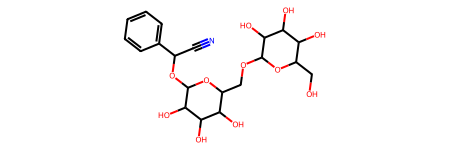

In [5]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

In [52]:
import torch
from torch.nn import Linear, BatchNorm1d, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, global_add_pool, SAGPooling

class GCNRegressionRegularized(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=64):
        super(GCNRegressionRegularized, self).__init__()
        torch.manual_seed(42)

        # Hyperparameters
        self.hidden_dim = hidden_dim

        # GCN layers
        self.initial_conv = GCNConv(num_features, self.hidden_dim)
        self.conv1 = GCNConv(self.hidden_dim, self.hidden_dim)
        self.conv2 = GCNConv(self.hidden_dim, self.hidden_dim)
        self.conv3 = GCNConv(self.hidden_dim, self.hidden_dim)
        self.pool1 = SAGPooling(self.hidden_dim, ratio=0.8)  # Sample and aggregate pooling
        
        # Batch normalization layers
        self.batch_norm1 = BatchNorm1d(self.hidden_dim)
        self.batch_norm2 = BatchNorm1d(self.hidden_dim)
        self.batch_norm3 = BatchNorm1d(self.hidden_dim)

        # Dropout layer
        self.dropout = Dropout(0.5)

        # Output layer
        self.out = Linear(self.hidden_dim * 2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        x = self.initial_conv(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # First pooling layer
        x, edge_index, _, batch_index, _, _ = self.pool1(x, edge_index, None, batch_index)

        # Second Conv layer
        x = self.conv1(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third Conv layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Fourth Conv layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Global Pooling (stack different aggregations)
        x = torch.cat([global_max_pool(x, batch_index), 
                       global_mean_pool(x, batch_index)], dim=1)

        # Apply a final (linear) classifier
        out = self.out(x)
        return out, None

# Assuming 'data.num_features' is defined
num_features = data.num_features  # Placeholder for number of node features
model = GCNRegressionRegularized(num_features=num_features)
print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

GCNRegressionRegularized(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (pool1): SAGPooling(GraphConv, 64, ratio=0.8, multiplier=1.0)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters: 13763


In [7]:
from torch_geometric.data import DataLoader
import torch
import warnings
import numpy as np

warnings.filterwarnings("ignore")

# Assuming model, data, and other dependencies are defined above

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train():
    model.train()
    total_loss = 0
    for batch in loader:
        batch.to(device)  
        optimizer.zero_grad() 
        pred, _ = model(batch.x.float(), batch.edge_index, batch.batch) 
        loss = loss_fn(pred, batch.y.view_as(pred))  # Ensure target shape matches prediction
        loss.backward()  
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch.to(device)  
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            loss = loss_fn(pred, batch.y.view_as(pred))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

train_losses = []
test_losses = []

# Early Stopping
best_test_loss = np.inf
epochs_no_improve = 0
n_epochs_stop = 500

print("Starting training...")
for epoch in range(2000):
    train_loss = train()
    test_loss = evaluate(test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Early stopping check
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= n_epochs_stop:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

if epochs_no_improve < n_epochs_stop:
    print("Completed all epochs without early stopping.")

Starting training...
Epoch 0 | Train Loss: 12.1792 | Test Loss: 10.9377
Epoch 100 | Train Loss: 1.4440 | Test Loss: 2.4844
Epoch 200 | Train Loss: 1.1248 | Test Loss: 3.6685
Epoch 300 | Train Loss: 0.9422 | Test Loss: 4.1136
Epoch 400 | Train Loss: 0.9295 | Test Loss: 4.6836
Epoch 500 | Train Loss: 0.8053 | Test Loss: 4.7934
Epoch 600 | Train Loss: 0.8270 | Test Loss: 4.9954
Early stopping at epoch 614


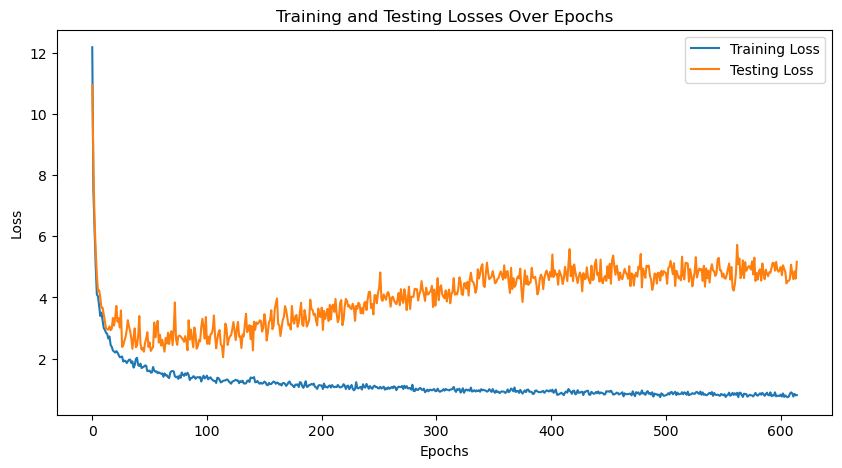

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='Training Loss')
sns.lineplot(x=range(len(test_losses)), y=test_losses, label='Testing Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-6.237,-1.358426
1,-0.660,0.210490
2,-7.390,-3.584897
3,-2.000,-0.694109
4,-2.349,0.325654
...,...,...
59,-2.518,-0.913852
60,-5.230,-1.469195
61,-2.120,-0.907209
62,0.100,0.262836


In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCNRegressionOverfitting(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCNRegressionOverfitting, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCNRegressionOverfitting()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [11]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 11.665947914123535
Epoch 100 | Train Loss 0.852439820766449
Epoch 200 | Train Loss 1.1218886375427246
Epoch 300 | Train Loss 0.32426807284355164
Epoch 400 | Train Loss 0.22870056331157684
Epoch 500 | Train Loss 0.3518277108669281
Epoch 600 | Train Loss 0.24165497720241547
Epoch 700 | Train Loss 0.06836222857236862
Epoch 800 | Train Loss 0.15930204093456268
Epoch 900 | Train Loss 0.14613784849643707
Epoch 1000 | Train Loss 0.0710400640964508
Epoch 1100 | Train Loss 0.05588055029511452
Epoch 1200 | Train Loss 0.10979975014925003
Epoch 1300 | Train Loss 0.0618143267929554
Epoch 1400 | Train Loss 0.032259661704301834
Epoch 1500 | Train Loss 0.01744488812983036
Epoch 1600 | Train Loss 0.04848362132906914
Epoch 1700 | Train Loss 0.023553645238280296
Epoch 1800 | Train Loss 0.09558268636465073
Epoch 1900 | Train Loss 0.06260276585817337


In [12]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,0.940,0.445751
1,-6.237,-2.845885
2,-2.540,-3.007201
3,-5.680,-5.744259
4,-2.460,-1.656750
...,...,...
59,-1.890,-1.474234
60,-2.218,-4.705441
61,-3.583,-1.599123
62,-2.580,-2.400562


We have some good result doing overfitting. While with the first model which was not  overfitting we had no good result.
&rarr; My hypothesis is that there are clusters; for example the easy predictible molecules and the others.
Let's do clustering 

In [ ]:
class GCNClustering(torch.nn.Module):
    def __init__(self, num_features, hidden_dim=64):
        super(GCNClustering, self).__init__()
        torch.manual_seed(42)
        self.hidden_dim = hidden_dim
        self.initial_conv = GCNConv(num_features, self.hidden_dim)
        self.conv1 = GCNConv(self.hidden_dim, self.hidden_dim)
        self.conv2 = GCNConv(self.hidden_dim, self.hidden_dim)
        self.conv3 = GCNConv(self.hidden_dim, self.hidden_dim)
        self.pool1 = SAGPooling(self.hidden_dim, ratio=0.8)
        self.batch_norm1 = BatchNorm1d(self.hidden_dim)
        self.batch_norm2 = BatchNorm1d(self.hidden_dim)
        self.batch_norm3 = BatchNorm1d(self.hidden_dim)
        self.dropout = Dropout(0.5)
        self.out = Linear(self.hidden_dim * 2, 1)

    def forward(self, x, edge_index, batch_index):
        x = self.initial_conv(x, edge_index)
        x = F.relu(self.batch_norm1(x))
        x = self.dropout(x)
        x, edge_index, _, batch_index, _, _ = self.pool1(x, edge_index, None, batch_index)
        x = F.relu(self.batch_norm2(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm3(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x_embed = torch.cat([global_max_pool(x, batch_index), global_mean_pool(x, batch_index)], dim=1)
        out = self.out(x_embed)
        return out, x_embed


In [15]:
all_embeddings = []
model.eval()
with torch.no_grad():
    for batch in DataLoader(data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False):
        batch.to(device)
        _, embeddings = model(batch.x.float(), batch.edge_index, batch.batch)
        all_embeddings.append(embeddings.cpu().numpy())

# Concatenate all embeddings into a single matrix
all_embeddings = np.vstack(all_embeddings)
all_embeddings.shape

(1128, 128)

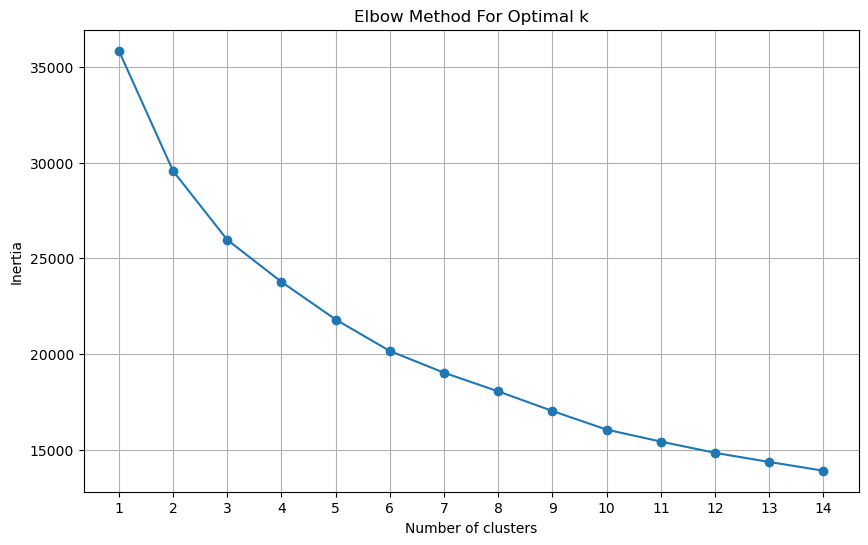

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming 'all_embeddings' is your matrix of embeddings
inertias = []
cluster_range = range(1, 15)  # Example: checking 1 to 14 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(all_embeddings)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()


No elbow, let's use DBSCAN

In [21]:
from sklearn.preprocessing import StandardScaler

def extract_embeddings(loader):
    model.eval()
    embeddings = []
    solubilities = []
    with torch.no_grad():
        for batch in loader:
            batch.to(device)
            _, embed = model(batch.x.float(), batch.edge_index, batch.batch)
            embeddings.append(embed.to('cpu').numpy())
            solubilities.append(batch.y.to('cpu').numpy())
    return np.vstack(embeddings), np.concatenate(solubilities)

# Gather all data in a single DataLoader for simplicity
full_loader = DataLoader(data, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

# Extract embeddings and solubilities
all_embeddings, all_solubilities = extract_embeddings(full_loader)

# Normalize solubilities and concatenate with embeddings
scaler = StandardScaler()
normalized_solubilities = scaler.fit_transform(all_solubilities.reshape(-1, 1))
enhanced_features = np.concatenate((all_embeddings, normalized_solubilities), axis=1)


k-means

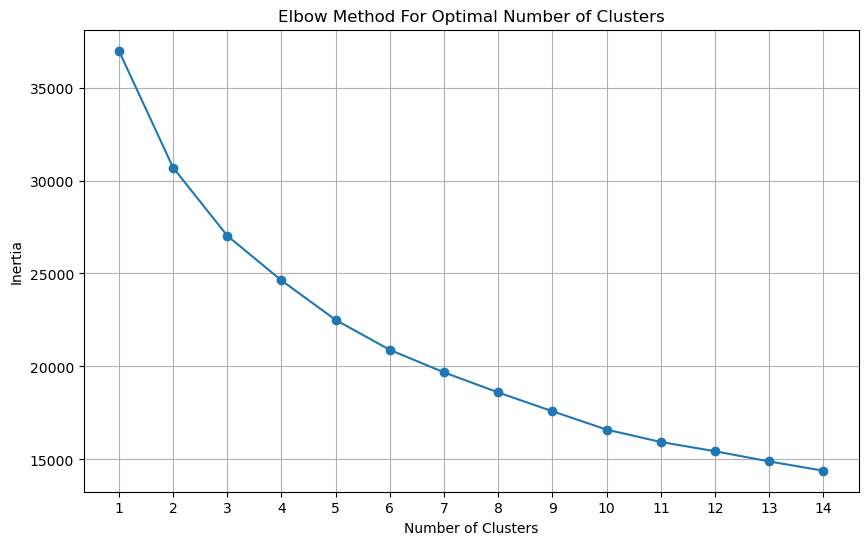

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of potential cluster numbers to evaluate
cluster_range = range(1, 15)  # for instance, from 1 to 14 clusters
inertias = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(enhanced_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertias, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [23]:
optimal_k = int(input("Enter the optimal number of clusters based on the elbow plot: "))
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_optimal.fit_predict(enhanced_features)

print(f"Number of clusters: {len(set(clusters))}")
print(f"Data points per cluster: {dict((i, list(clusters).count(i)) for i in range(optimal_k))}")


Number of clusters: 2
Data points per cluster: {0: 412, 1: 716}


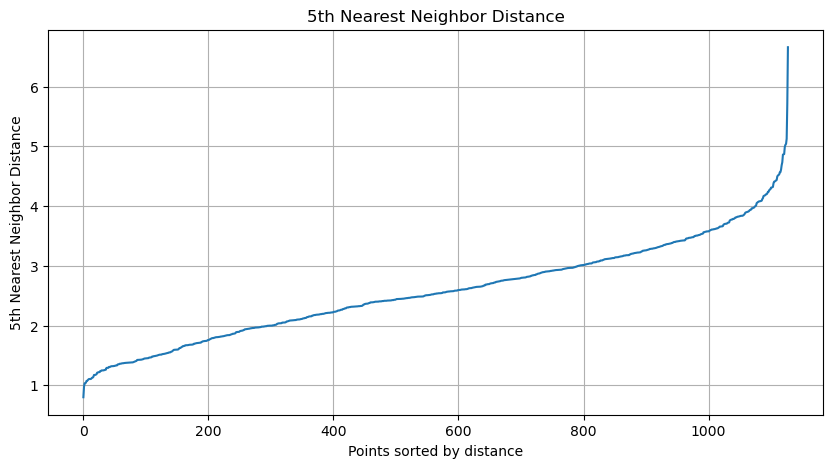

In [20]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(enhanced_features)
distances, indices = neighbors_fit.kneighbors(enhanced_features)

# Sort the distances
distances = np.sort(distances, axis=0)
distances = distances[:, 4]  # Taking the distance to the 5th nearest neighbor

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('5th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(True)
plt.show()

In [24]:
print(enhanced_features.shape)

(1128, 129)


In [125]:
# Clustering with DBSCAN as an example
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=3.15, min_samples=20)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(enhanced_features)

# Analyze clustering results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {list(clusters).count(-1)}")

Number of clusters: 6
Number of noise points: 591


In [126]:
for cluster in range(n_clusters):
    cluster_mask = (clusters == cluster)
    cluster_data = enhanced_features[cluster_mask]
    print(f"Cluster {cluster} size: {len(cluster_data)}")

Cluster 0 size: 27
Cluster 1 size: 41
Cluster 2 size: 382
Cluster 3 size: 16
Cluster 4 size: 51
Cluster 5 size: 20


In [104]:
selected_cluster = data[(clusters == 2)]

Let's assume that since the cluster 2 is big it's the "easy predictible" molecules

In [105]:
from torch_geometric.data import DataLoader

selected_cluster = [i for i, label in enumerate(clusters) if label == 0]
cluster_2_data = [data[i] for i in selected_cluster]

# Splitting cluster_0_data into training and testing sets
train_size = int(0.8 * len(cluster_2_data))
train_dataset = cluster_2_data[:train_size]
test_dataset = cluster_2_data[train_size:]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [106]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GCNRegressionRegularized(num_features=data.num_features).to(device)  # assuming data.num_features is defined
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
loss_fn = torch.nn.MSELoss()

print(model)
print("Number of parameters:", sum(p.numel() for p in model.parameters()))

GCNRegressionRegularized(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (pool1): SAGPooling(GraphConv, 64, ratio=0.8, multiplier=1.0)
  (batch_norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters: 13763


In [107]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, SAGPooling

# Ensure the model, loss function, and optimizer are defined as before

# Train and evaluate the model
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y.view_as(pred))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch.to(device)
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch)
            loss = loss_fn(pred, batch.y.view_as(pred))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

# Adjust the early stopping and training epochs as needed

In [108]:
train_losses = []
test_losses = []
best_test_loss = np.inf
epochs_no_improve = 0
n_epochs_stop = 500

print("Starting training...")
for epoch in range(2000):
    train_loss = train()
    test_loss = evaluate(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= n_epochs_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

if epochs_no_improve < n_epochs_stop:
    print("Completed all epochs without early stopping.")

Starting training...
Epoch 0 | Train Loss: 59.4289 | Test Loss: 55.7025
Epoch 100 | Train Loss: 7.3306 | Test Loss: 7.3901
Epoch 200 | Train Loss: 3.2574 | Test Loss: 4.3207
Epoch 300 | Train Loss: 1.5675 | Test Loss: 3.3022
Epoch 400 | Train Loss: 0.8932 | Test Loss: 2.1250
Epoch 500 | Train Loss: 0.7557 | Test Loss: 1.5027
Epoch 600 | Train Loss: 0.9221 | Test Loss: 2.9948
Epoch 700 | Train Loss: 1.0902 | Test Loss: 0.7147
Epoch 800 | Train Loss: 1.0024 | Test Loss: 0.9444
Epoch 900 | Train Loss: 0.9452 | Test Loss: 0.7687
Epoch 1000 | Train Loss: 0.8489 | Test Loss: 0.8915
Epoch 1100 | Train Loss: 0.9760 | Test Loss: 1.8610
Epoch 1200 | Train Loss: 0.6400 | Test Loss: 0.8744
Epoch 1300 | Train Loss: 0.6603 | Test Loss: 0.8571
Early stopping at epoch 1335


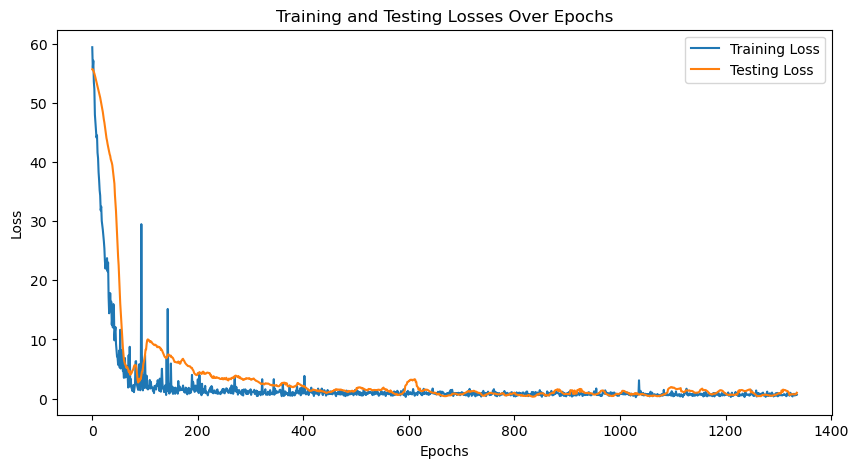

In [109]:
# Plot training and testing losses
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='Training Loss')
sns.lineplot(x=range(len(test_losses)), y=test_losses, label='Testing Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [110]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-8.600,-7.505211
1,-8.040,-6.372198
2,-7.010,-6.320487
3,-6.726,-6.163582
4,-7.800,-7.446160
5,-6.680,-5.654646


In [111]:
train_losses = []
test_losses = []
best_train_loss = np.inf
epochs_no_improve = 0
n_epochs_stop = 500

print("Starting training...")
for epoch in range(2000):
    train_loss = train()
    test_loss = evaluate(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= n_epochs_stop:
        print(f"Early stopping at epoch {epoch}")
        break
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

if epochs_no_improve < n_epochs_stop:
    print("Completed all epochs without early stopping.")

Starting training...
Epoch 0 | Train Loss: 0.7663 | Test Loss: 1.2902
Epoch 100 | Train Loss: 0.6932 | Test Loss: 1.0486
Epoch 200 | Train Loss: 0.5450 | Test Loss: 0.8247
Epoch 300 | Train Loss: 0.7225 | Test Loss: 1.6531
Epoch 400 | Train Loss: 0.5341 | Test Loss: 1.0768
Epoch 500 | Train Loss: 0.4680 | Test Loss: 0.4630
Early stopping at epoch 512


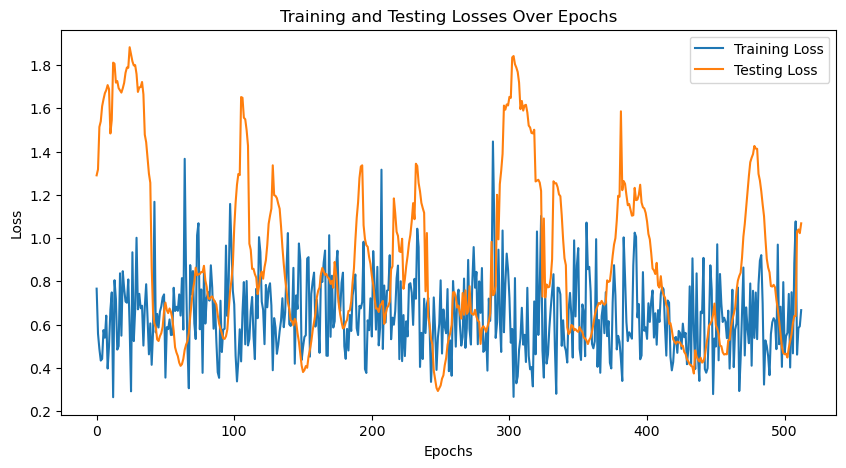

In [127]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(train_losses)), y=train_losses, label='Training Loss')
sns.lineplot(x=range(len(test_losses)), y=test_losses, label='Testing Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [112]:
import pandas as pd 

# Analyze the results for one batch
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,-8.600,-7.649957
1,-8.040,-6.133715
2,-7.010,-6.181642
3,-6.726,-6.353044
4,-7.800,-7.565367
5,-6.680,-5.683395


Quite okay